In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carrega a tabela imortação
imp_fert=pd.read_csv('~/git/BD/temp/imp_fert1.csv')

A coluna CO_UNID esta ocasionado uma triangulação entre tabelas e, de início, isso que parece um erro da origem, será sanado.

In [2]:
imp_fert.CO_UNID.unique()

array([10])

In [3]:
# Carrega a tabela complementar NCM_unidade
ncm_unid=pd.read_csv('~/git/BD/Comexstat/tab_complementares/NCM_UNIDADE.csv', encoding='Latin-1',sep=';')

In [4]:
# verifica o nome das unidades utilkkizadas em imp_fert
imp_fert.merge(ncm_unid).NO_UNID.unique()

array(['QUILOGRAMA LIQUIDO'], dtype=object)

In [5]:
# Carrega a tabela complementar NCM
ncm=pd.read_csv('~/git/BD/Comexstat/tab_complementares/NCM.csv', encoding='Latin-1',sep=';')

In [6]:
ncm=ncm.merge(imp_fert[['CO_UNID']].drop_duplicates())

In [7]:
ncm=ncm.drop(columns=ncm.columns[1:11])
ncm=ncm.drop(columns=ncm.columns[12:14])

In [8]:
# Funde as tabelas
imp_fert=imp_fert.merge(ncm)

In [9]:
imp_fert=imp_fert.drop(columns='CO_UNID')

Filtra os registros de importação, deixando passar somente os referentes aos NCMs top 10 em peso total importado no período.

In [10]:
# Ranqueia a seleciona os 10 maiores NCMs em peso
imp_fert_top=imp_fert.groupby('CO_NCM').KG_LIQUIDO.sum().sort_values(ascending=False).reset_index().head(10)['CO_NCM'].values

# Filtra a tabela deixano passar somente os registros dos NCMs top
imp_fert=imp_fert[imp_fert.CO_NCM.isin(imp_fert_top)]

Dá nome abreviado e de uso comum aos NCMs

In [11]:
pd.options.display.max_colwidth = 150

In [12]:
tab_name=imp_fert[['CO_NCM','NO_NCM_POR']].drop_duplicates().assign(name=imp_fert.NO_NCM_POR).sort_values('name')

In [13]:
name=['NPK','MAP','NAM','NP','MOP','OSP','SAM','SSP','TSP','UREIA']

In [14]:
tab_name.name=name

In [15]:
imp_fert=imp_fert.merge(tab_name)

Confere exigências básicas

In [16]:
# Confere existência de duplicatas
print(f"Exitem {imp_fert.loc[:,:'CO_URF'].duplicated().sum()} duplicatas das colunas categóricas")

Exitem 0 duplicatas das colunas categóricas


In [17]:
# Confere existência de nan
print(f"Exitem {imp_fert.isna().sum().sum()} NANs nos registros")

Exitem 0 NANs nos registros


In [18]:
# Carrega função que corrige inflação do dólar
%run 'corrige_inflação_dólar.ipynb'


Função ***corrige_inflação_dólar(df_ano_mes_valor,col_vl_name)*** disponível.



In [19]:
# Corrige inflação do dólar
for col in ['VL_FOB','VL_FRETE','VL_SEGURO']:
    df=corrige_inflação_dólar(imp_fert,col)

In [20]:
# %  de valor em registros com peso igual a zero
print(f"Valor contido nos registros com peso igual a zero corresponde a \
{round(100 * imp_fert[imp_fert.KG_LIQUIDO==0].VL_FOB.sum() / imp_fert.VL_FOB.sum())} % do total e foram descartados.")

# Descarta peso igual a zero
imp_fert=imp_fert[imp_fert.KG_LIQUIDO!=0]

Valor contido nos registros com peso igual a zero corresponde a 0 % do total e foram descartados.


In [21]:
# %  de peso em registros com valor igual a zero
print(f"Peso contido nos registros com valor igual a zero corresponde a \
{round(100 * imp_fert[imp_fert.VL_FOB==0].KG_LIQUIDO.sum() / imp_fert.KG_LIQUIDO.sum())} % do total e foram descartados.")

# Descarta valor igual a zero
imp_fert=imp_fert[imp_fert.VL_FOB!=0]

Peso contido nos registros com valor igual a zero corresponde a 0 % do total e foram descartados.


In [22]:
# Verifica participação das vias no peso total importado
rank_vias=imp_fert.groupby('CO_VIA').KG_LIQUIDO.sum().sort_values(ascending=False).reset_index()
rank_vias

,CO_VIA,KG_LIQUIDO
0,1,506608371206
1,7,797414800
2,6,159185663
3,2,5303290
4,4,226995
5,9,10000
6,5,1


In [23]:
# Identifica a via líder em movimentação 
via=pd.read_csv('~/git/BD/Comexstat/tab_complementares/VIA.csv',encoding='Latin-1',sep=';')
print(f"A via amplamente líder é a {via[via.CO_VIA==rank_vias.CO_VIA.values[0]].NO_VIA.values[0]}, código {via[via.CO_VIA==rank_vias.CO_VIA.values[0]].CO_VIA.values[0]}. As demais serão descartadas.")

A via amplamente líder é a MARITIMA, código 1. As demais serão descartadas.


In [24]:
# Filtra deixando passar somente  a via 1
imp_fert=imp_fert[imp_fert.CO_VIA==1]

In [25]:
# Descarta as colunas como previsto
imp_fert.drop(columns=['CO_VIA','QT_ESTAT'],inplace=True)

In [26]:
print(f' {round(imp_fert[imp_fert.VL_FRETE==0].KG_LIQUIDO.sum()/10**3)} toneladas e {round(imp_fert[imp_fert.VL_FRETE==0].VL_FOB.sum()/10**3)} \
mil de dólares de mercadoria constam em {len(imp_fert[imp_fert.VL_FRETE==0])} registros com valor de frete igual a zero e estes serão descartados.')

 572 toneladas e 85 mil de dólares de mercadoria constam em 90 registros com valor de frete igual a zero e estes serão descartados.


In [27]:
imp_fert=imp_fert[imp_fert.VL_FRETE!=0]

In [28]:
# Confere existência de quantidades negativas
print(f'Existem {round(len(imp_fert[(imp_fert.VL_FOB<0)|(imp_fert.VL_FRETE<0)|(imp_fert.KG_LIQUIDO<0)]))} registros com quantidades negativas.')

Existem 0 registros com quantidades negativas.


Visualiza cronologicamente o valor FOB e o peso por NCM

In [29]:
# Define o título dos gráficos
title='Importação de Fertilizantes'

In [30]:
# Insere coluna com a data
imp_fert.insert(0,'date',pd.to_datetime(imp_fert.CO_ANO.astype(str)+'/'+imp_fert.CO_MES.astype(str)+'/1'))

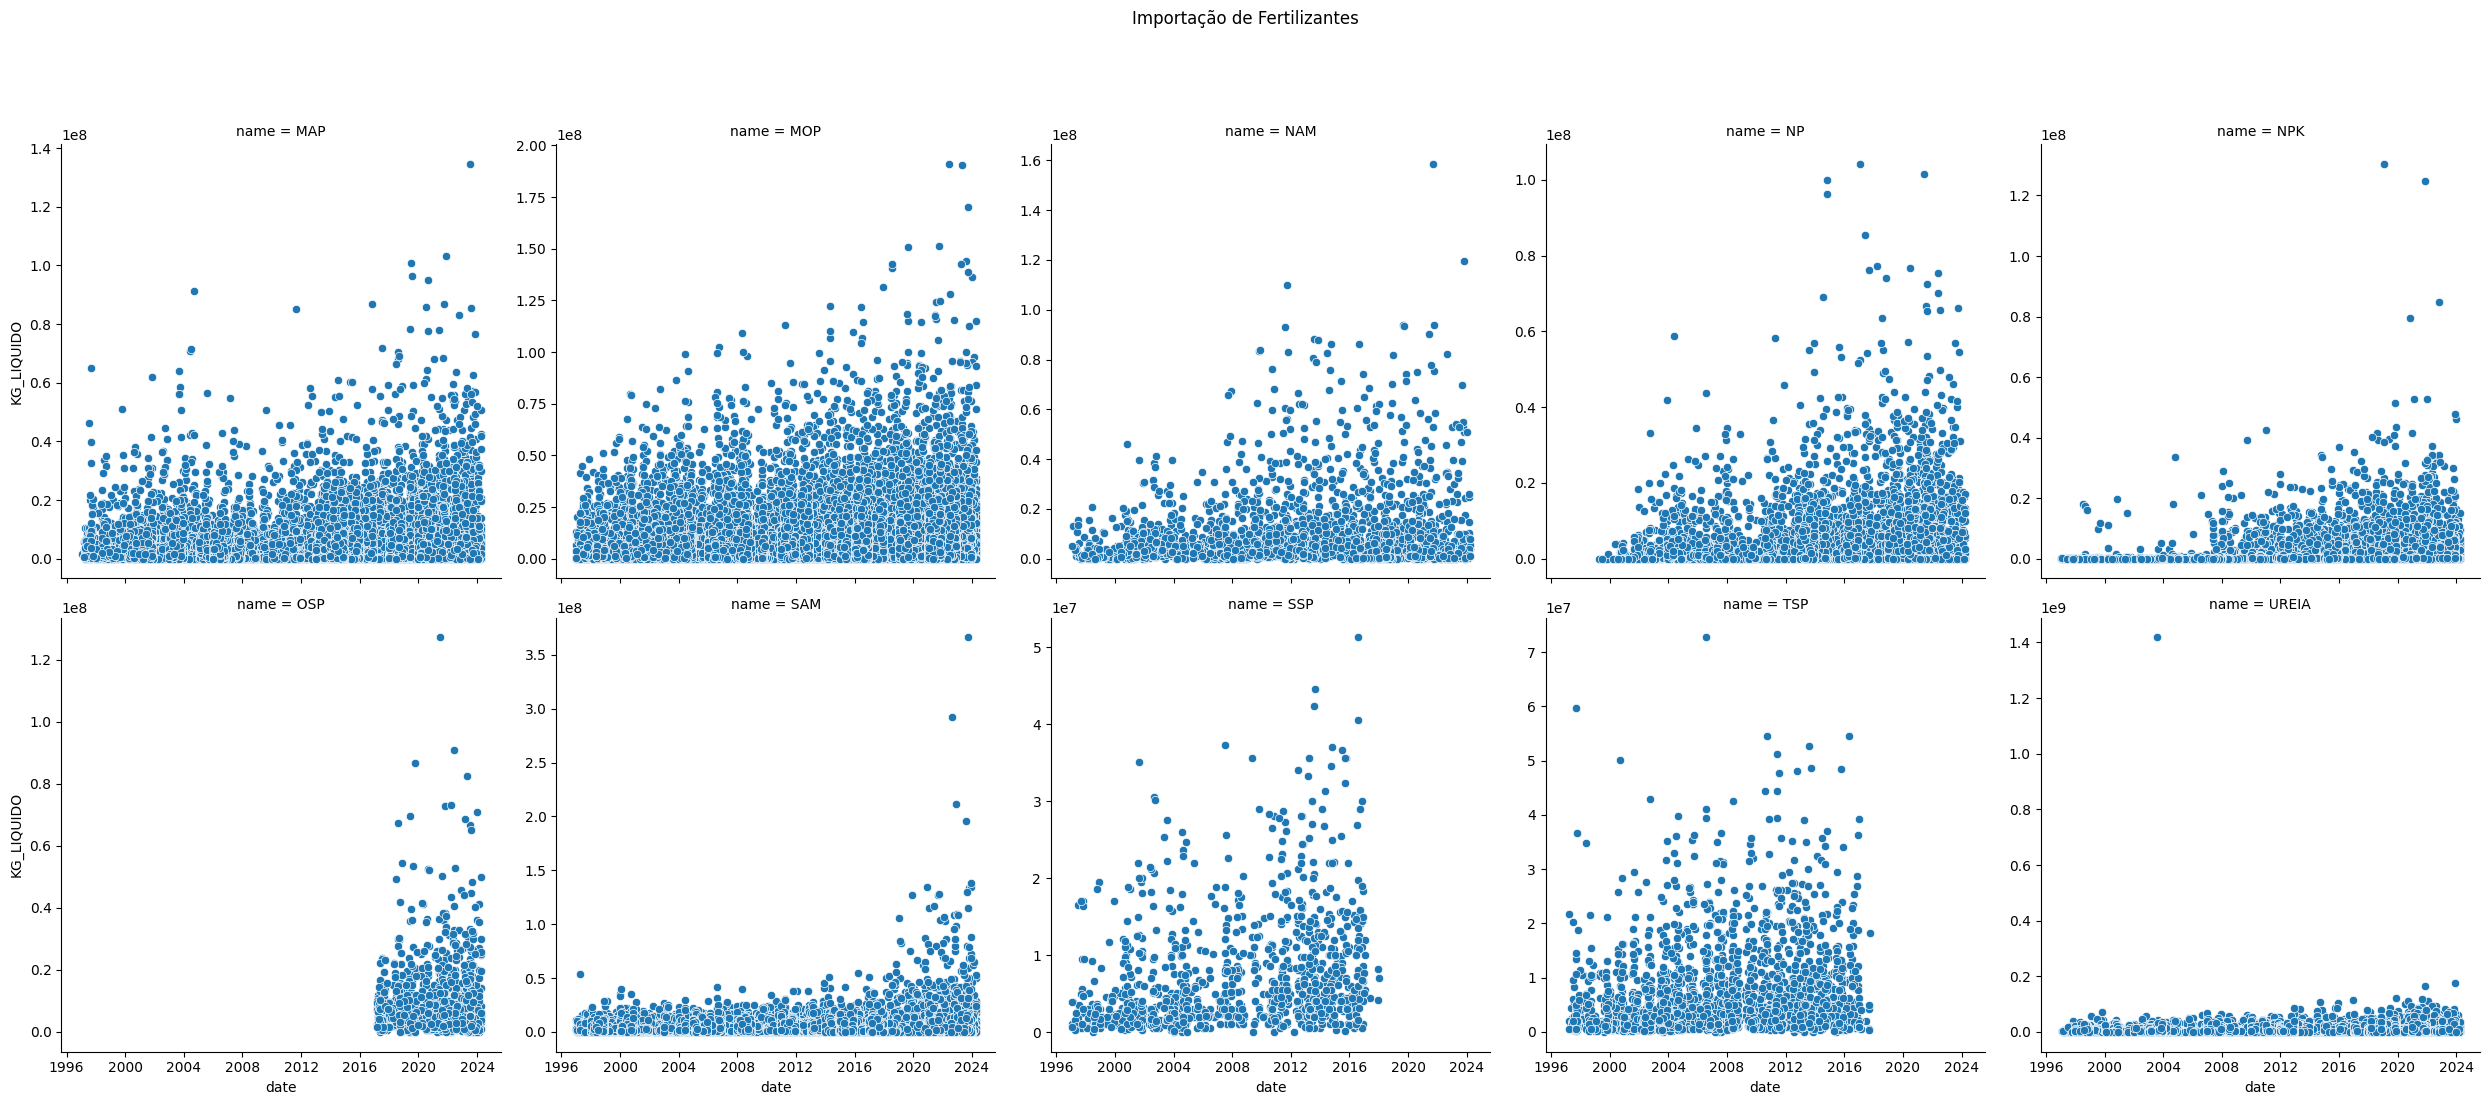

In [31]:
# Visualiza cronologicamenete os pesos por NCM
sns.relplot(data=imp_fert.sort_values('name'),x='date',y='KG_LIQUIDO', col='name', col_wrap=5, facet_kws=dict(sharey=False))\
.fig.suptitle(title,y=1.1)
plt.show()

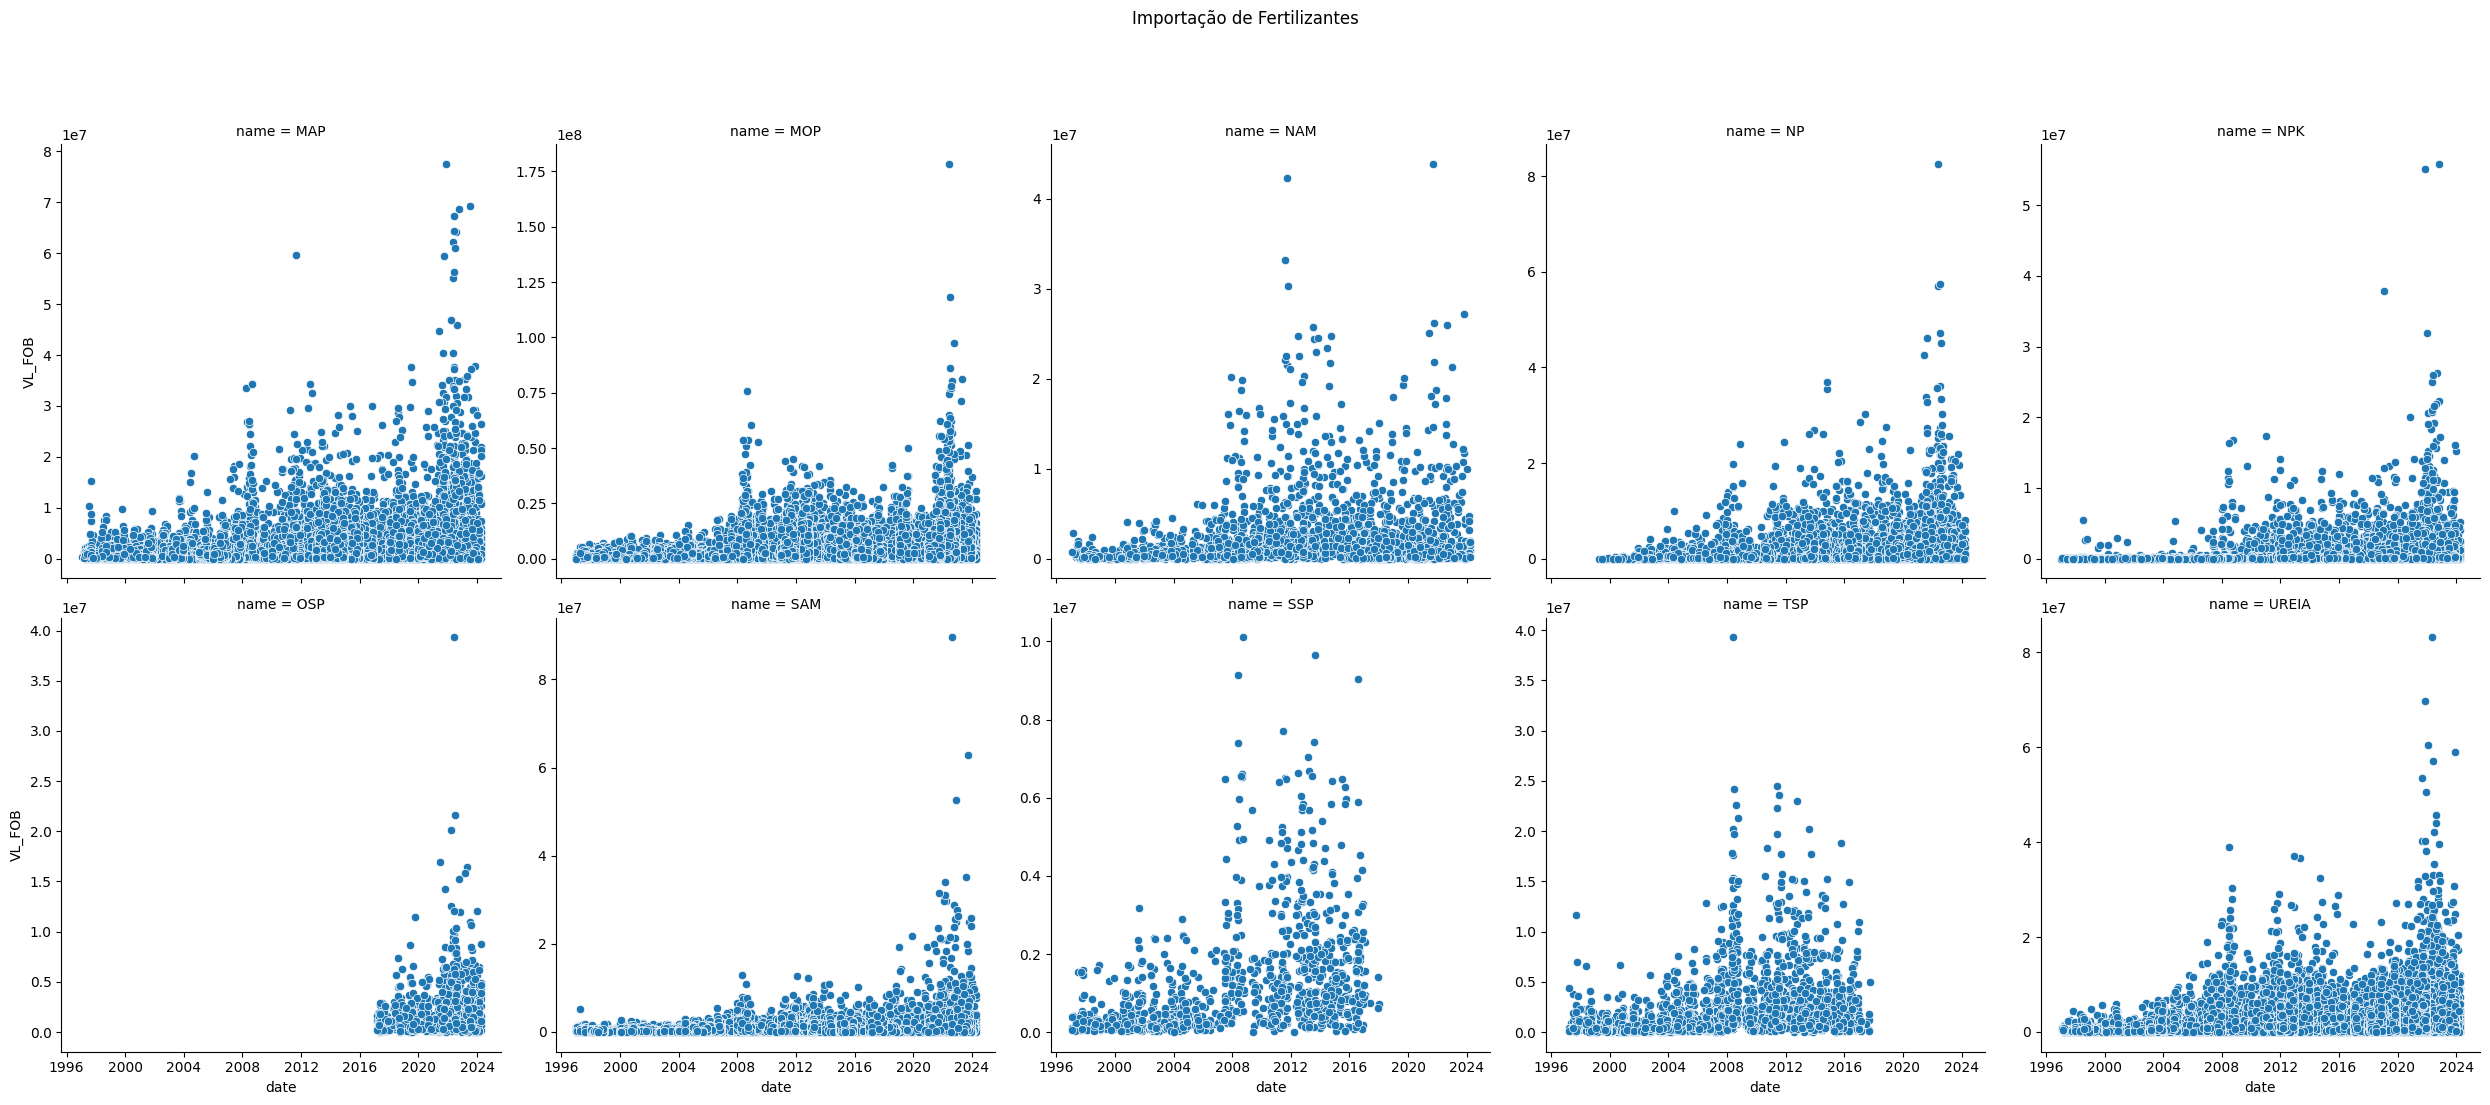

In [32]:
# Visualiza cronologicamenete os valores por NCM
sns.relplot(data=imp_fert.sort_values('name'),x='date',y='VL_FOB', col='name', col_wrap=5, facet_kws=dict(sharey=False))\
.fig.suptitle(title,y=1.1)
plt.show()

In [33]:
# Descarta os 3 tipos de superfosfatos, pois estes produtos apresentam complexidade extra na composição química, que levaram a alteração do
# código NCM durante o período de registro.
descarte=['SSP','TSP','OSP','XSP']
imp_fert=imp_fert[~imp_fert.name.isin(descarte)]

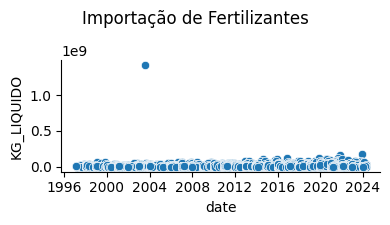

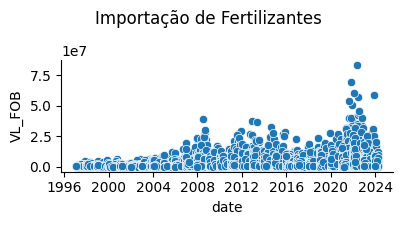

In [34]:
# Visualiza cronologicamenete os pesos por NCM
sns.relplot(height=2,aspect=2,data=imp_fert[imp_fert.name.isin(['UREIA'])],x='date',y='KG_LIQUIDO', facet_kws=dict(sharey=False))\
.fig.suptitle(title,y=1.1)
plt.show()

# Visualiza cronologicamenete os valores por NCM
sns.relplot(height=2,aspect=2,data=imp_fert[imp_fert.name.isin(['UREIA'])],x='date',y='VL_FOB', facet_kws=dict(sharey=False))\
.fig.suptitle(title,y=1.1)
plt.show()

In [35]:
# Corrige erro do tipo aleatório que visualmente comprime os registros de peso na parte baixa do gráfico da ureia.
# O erro é confirmado também pela inexistência de um valor FOB destacado na mesma proporção.

# Crai tabela temporária somente com o registro do erro máximo
imp_fert_err=imp_fert[imp_fert.KG_LIQUIDO==imp_fert.KG_LIQUIDO.max()]

# Cria tabela temporária sem o erro registro do erro máximo
imp_fert_correto=imp_fert[imp_fert.KG_LIQUIDO!=imp_fert.KG_LIQUIDO.max()]

# Identifica data e NCM do erro
data_prdt_err=imp_fert_err[['date','name']]

# Identifica registros sem erro na mesma data com o mesmo produto
imp_fert_correto_data_err=imp_fert_correto.merge(data_prdt_err)

# Calcula soma do valores e pesos corretos na data e para o produto do erro
imp_fert_correto_data_err=imp_fert_correto_data_err.groupby('name')[['VL_FOB','KG_LIQUIDO']].sum()

# Cálcula o preço médio correto do produto na data do erro
preço_correção=(imp_fert_correto_data_err.VL_FOB / imp_fert_correto_data_err.KG_LIQUIDO).values[0]

# Cálcula o preço correto do produto na data do erro, e o insere na tabela com erro
#imp_fert_correto_data_err=imp_fert_correto_data_err.assign(preço=preço_correção)
#preço_correção=imp_fert_correto_data_err.preço.values[0]

# Através do valor importado, que já estava correto, e do preço corrigido, se determina o peso corrigido
imp_fert_err.loc[:,'KG_LIQUIDO']=round(imp_fert_err.VL_FOB / preço_correção).astype(int)

# Conclui a correção
imp_fert_corrigido=imp_fert_err

# Concatena importações corrigidas e originalmente corretas
imp_fert=pd.concat([imp_fert_corrigido,imp_fert_correto])

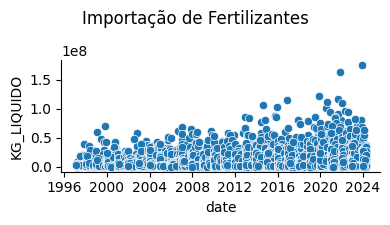

In [36]:
# Visualiza cronologicamenete os pesos da Ureia após a correção
sns.relplot(height=2,aspect=2,data=imp_fert[imp_fert.name.isin(['UREIA'])],x='date',y='KG_LIQUIDO', facet_kws=dict(sharey=False))\
.fig.suptitle(title,y=1.1)
plt.show()

# Normalizando por NCM

In [37]:
imp_fert1=imp_fert.copy()

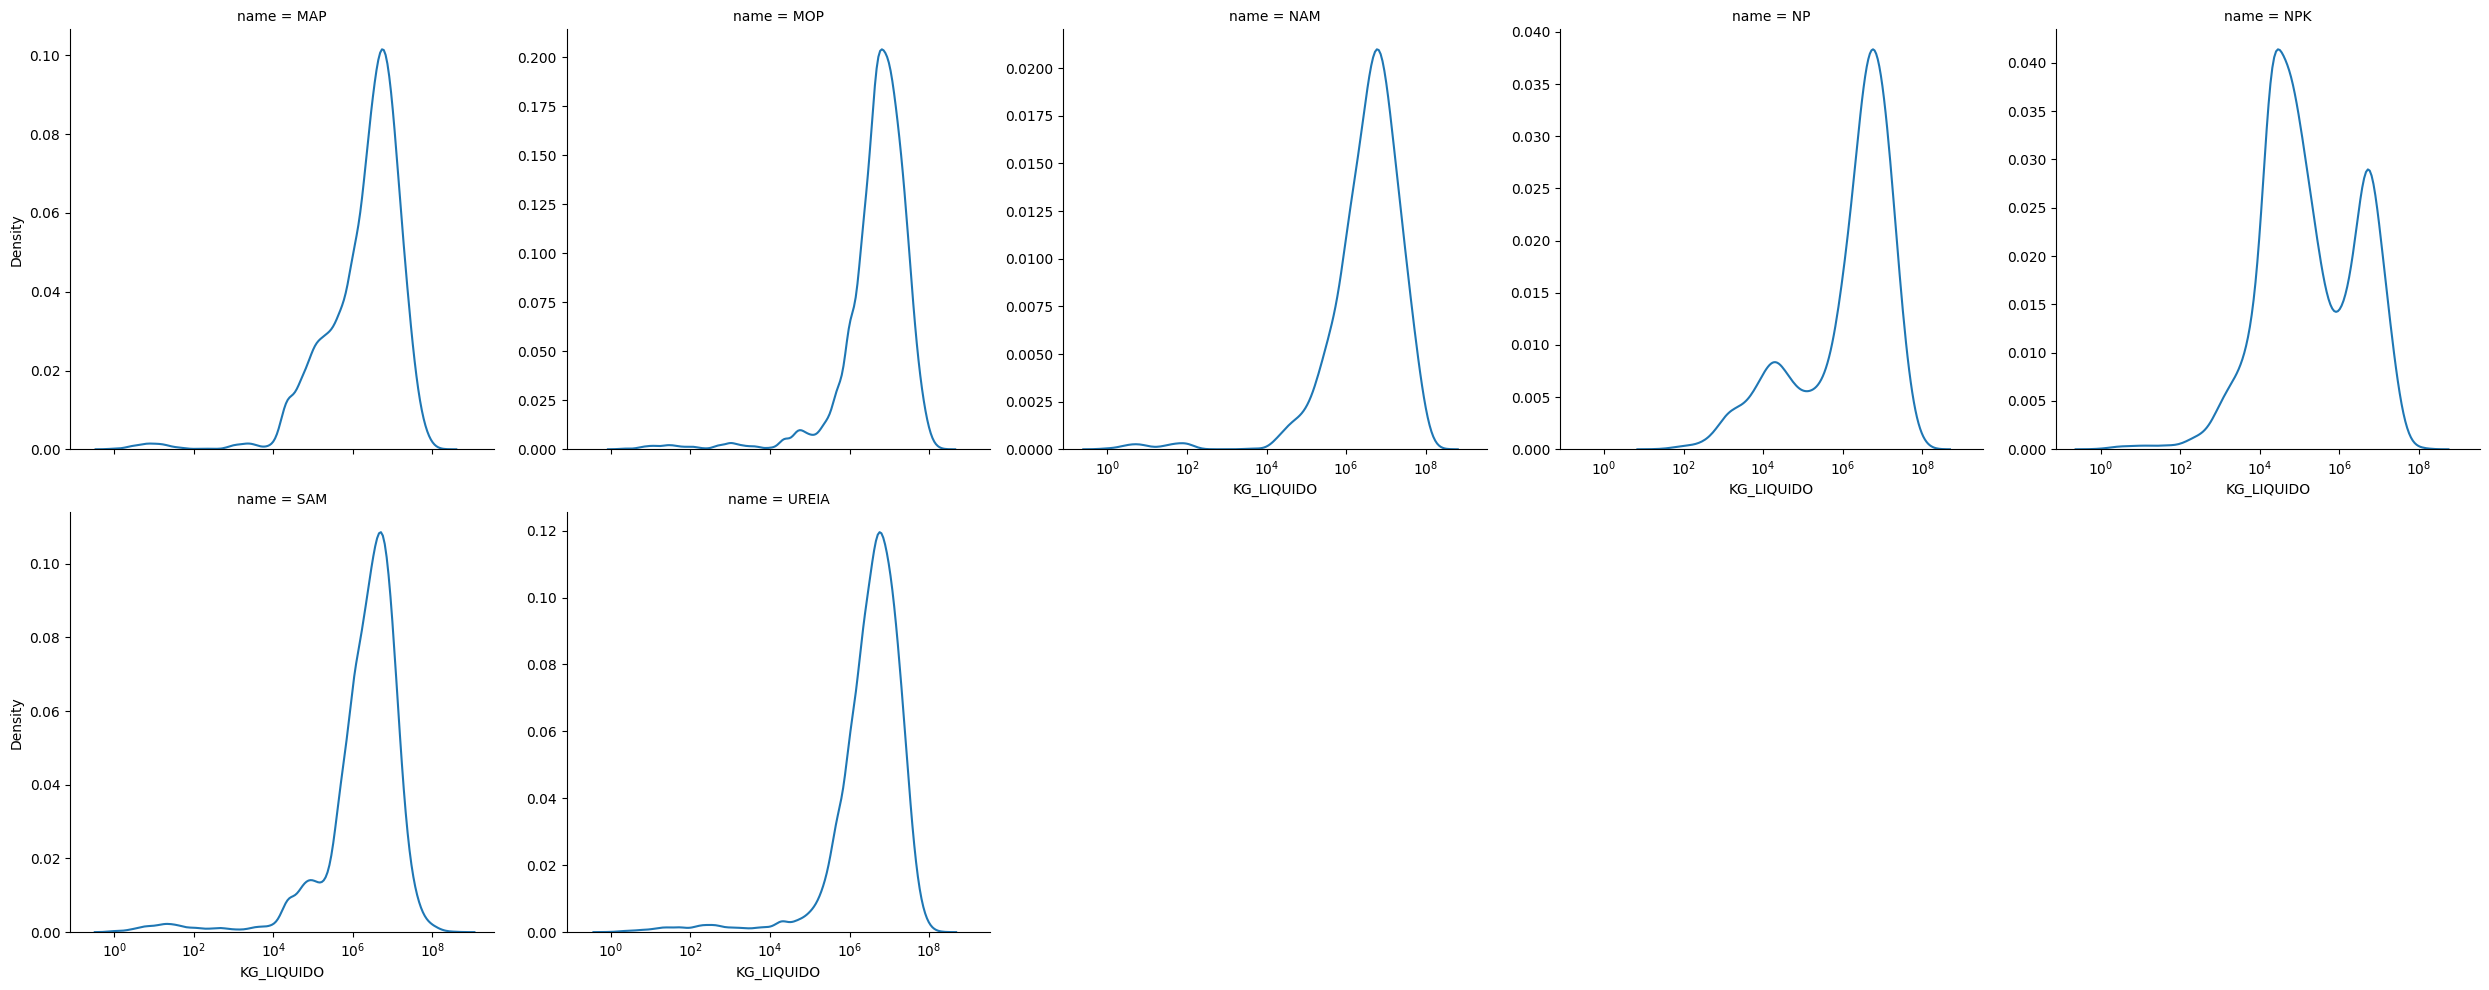

In [38]:
sns.displot(kind='kde',data=imp_fert.sort_values(by='name'),x='KG_LIQUIDO',col='name',col_wrap=5, log_scale=True, facet_kws=dict(sharey=False))
plt.show()

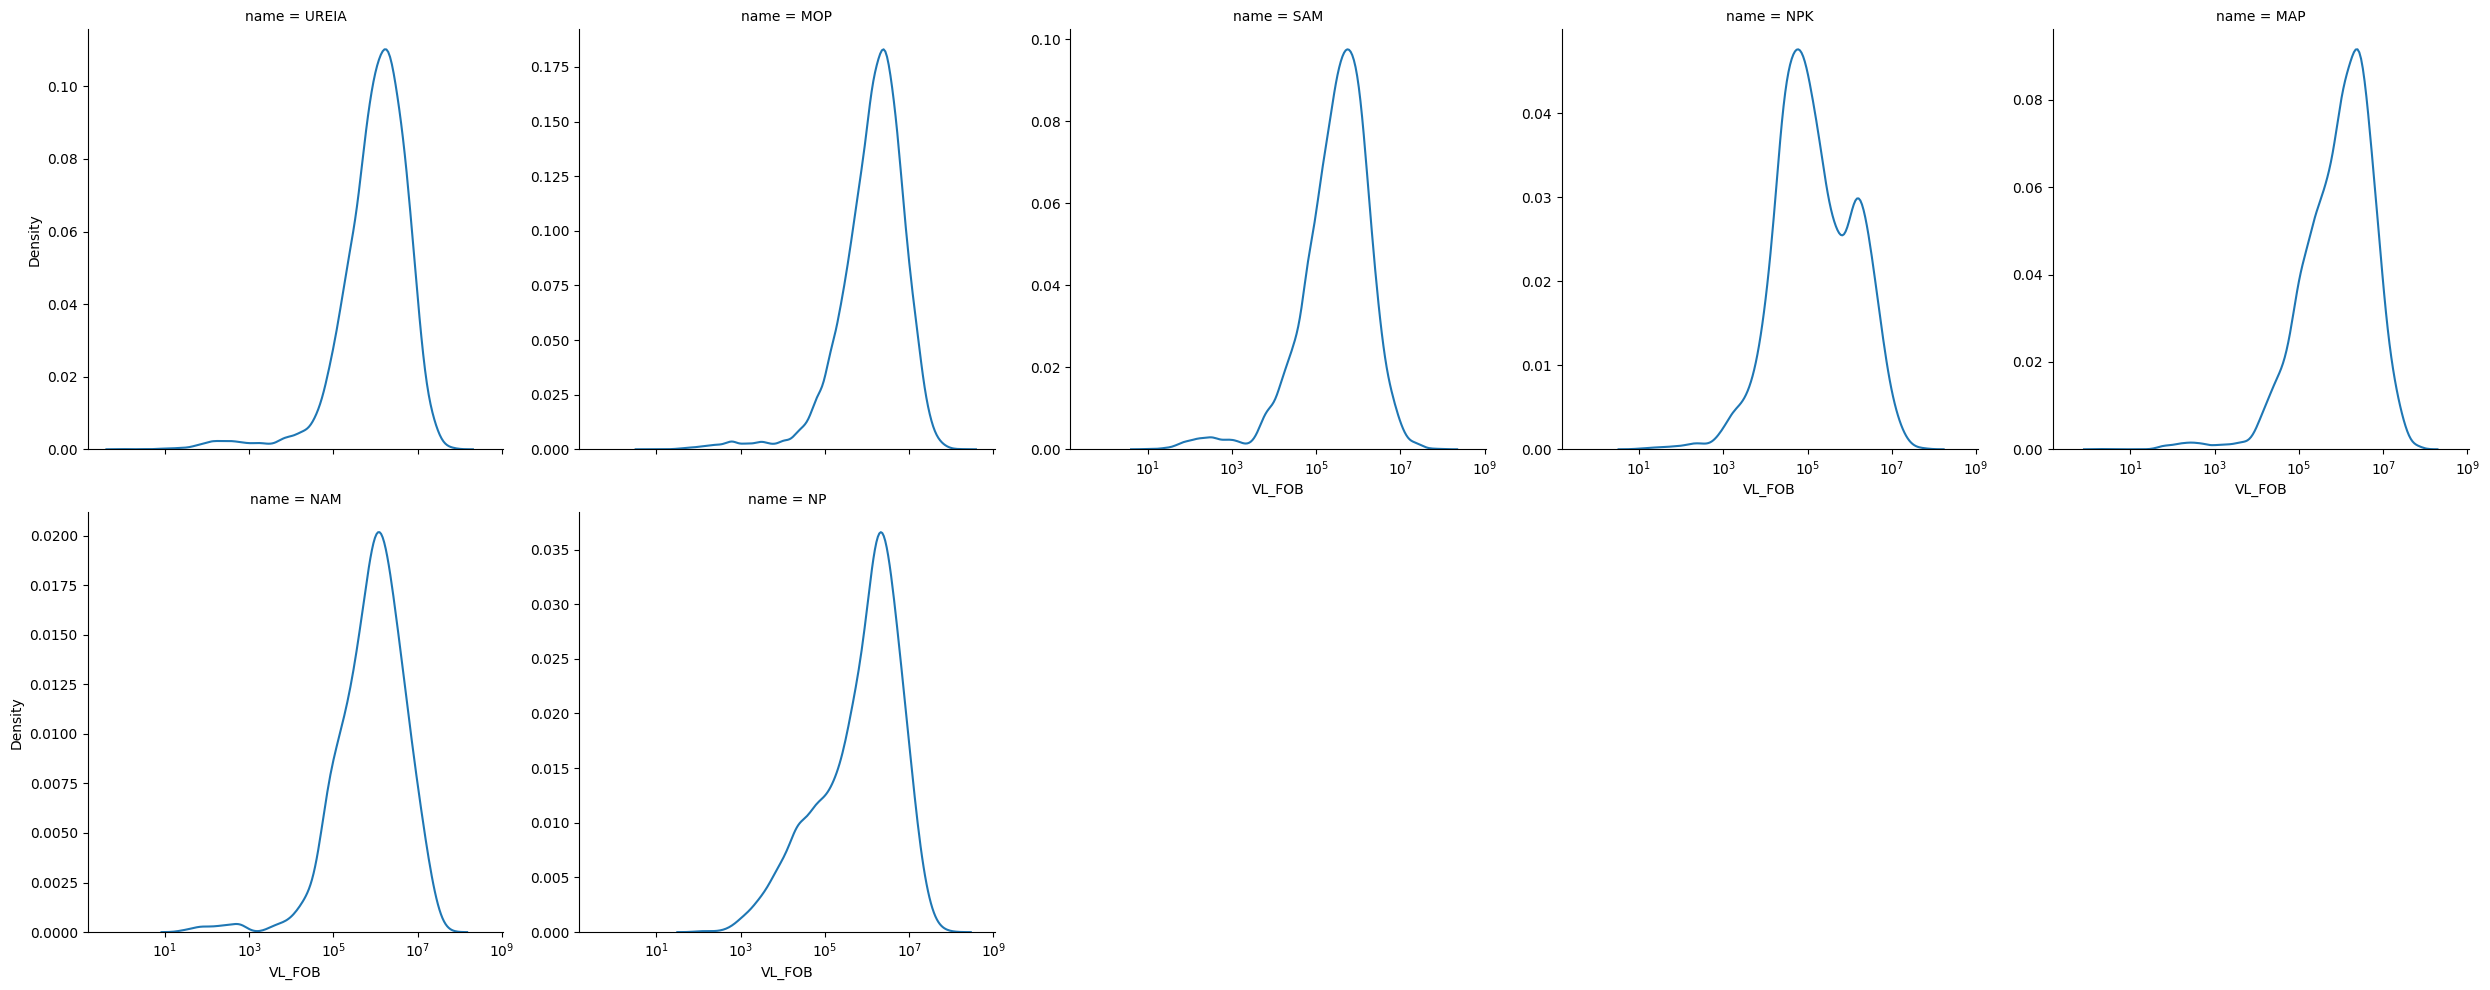

In [39]:
sns.displot(kind='kde',data=imp_fert,x='VL_FOB',col='name',col_wrap=5, log_scale=True, facet_kws=dict(sharey=False))
plt.show()

Se observa anormalidades no lado direito da distribuição de valores, alguns NCMs chegando a bimodalidade.

Se dividirão os NCMs em clusters.

In [40]:
imp_fert=imp_fert.assign(preço_frete=imp_fert.VL_FRETE/imp_fert.KG_LIQUIDO)
imp_fert=imp_fert.assign(preço_fob=imp_fert.VL_FOB/imp_fert.KG_LIQUIDO)

imp_fert=imp_fert.assign(log_kg=np.log10(imp_fert.KG_LIQUIDO))

imp_fert=imp_fert.assign(log_fob=np.log10(imp_fert.VL_FOB))

imp_fert=imp_fert.assign(log_frete=np.log10(imp_fert.VL_FRETE))

from sklearn.preprocessing import MinMaxScaler as MMS
MMS=MMS()

imp_fert=pd.concat([imp_fert.reset_index(drop=True),\
                 pd.DataFrame(MMS.fit_transform(imp_fert[['log_kg','log_fob','log_frete','preço_fob','preço_frete']]),\
                              columns=['log_kg_s','log_fob_s','log_frete_s','preço_fob_s','preço_frete_s'])]\
                ,axis=1)

In [41]:
from sklearn.cluster import KMeans as KM
KM=KM(n_clusters=2)

q=pd.DataFrame()
for name in imp_fert.name.unique():
    imp_fert_t=imp_fert[imp_fert.name==name]
    imp_fert_t=imp_fert_t.assign(km=KM.fit_predict(imp_fert_t[['log_kg_s','log_fob_s','log_frete_s','preço_fob_s','preço_frete_s']]))
    q=pd.concat([q,imp_fert_t])
imp_fert=q

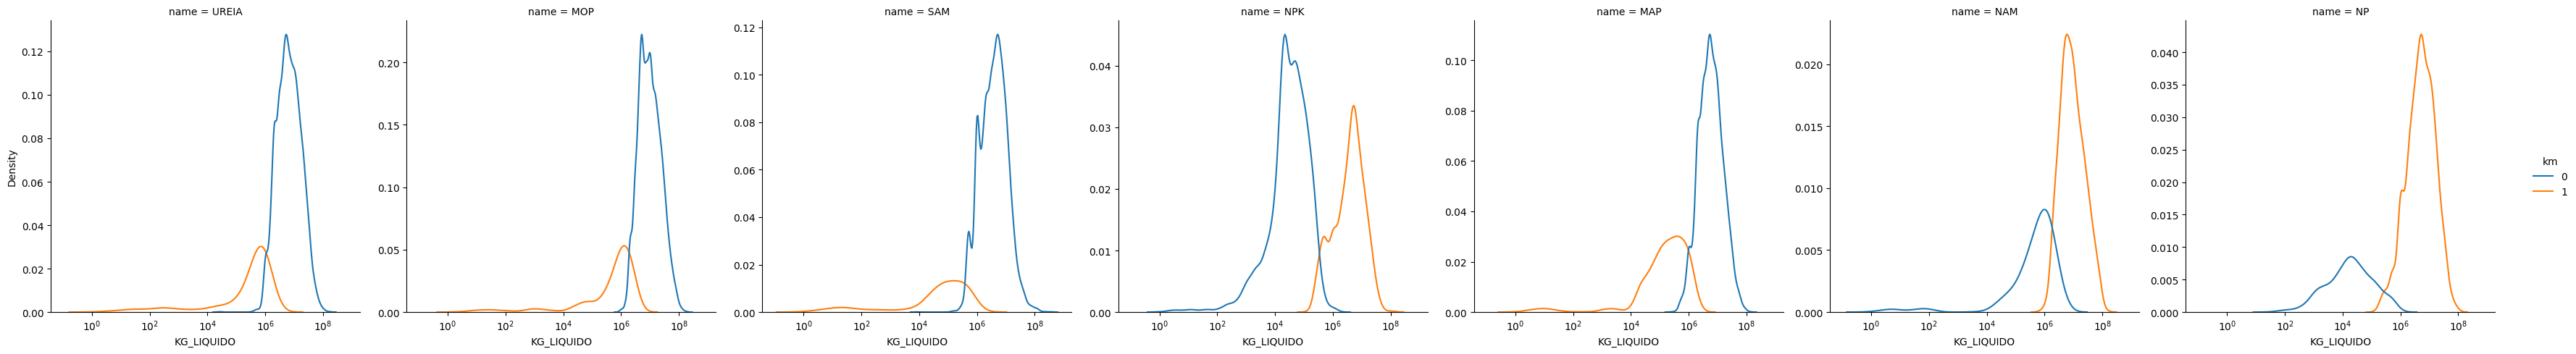

In [42]:
sns.displot(kind='kde',data=imp_fert,x='KG_LIQUIDO',col='name', log_scale=True, facet_kws=dict(sharey=False),hue='km')
plt.show()

In [43]:
imp_fert_tab=imp_fert.groupby(by=['name','CO_NCM', 'km']).KG_LIQUIDO.mean().reset_index()\
.sort_values(by=['name','KG_LIQUIDO','CO_NCM'], ascending=False)\
.rename(columns={'KG_LIQUIDO':'mean'})
#imp_fert_tab['CO_NCM_new']=imp_fert_tab.CO_NCM+'-'+imp_fert_tab.km.astype(str)
imp_fert_tab

,name,CO_NCM,km,mean
12,UREIA,31021010,0,1.035378e+07
13,UREIA,31021010,1,6.180017e+05
10,SAM,31022100,0,6.732935e+06
11,SAM,31022100,1,1.777443e+05
9,NPK,31052000,1,6.555285e+06
8,NPK,31052000,0,6.933889e+04
7,NP,31055900,1,8.888545e+06
6,NP,31055900,0,6.868580e+04
5,NAM,31023000,1,1.472464e+07
4,NAM,31023000,0,9.280590e+05


In [44]:
ad_name=['-hi','-low']*(int(len(imp_fert_tab)/2))

In [45]:
imp_fert_tab=imp_fert_tab.assign(ad_name=ad_name)

In [46]:
imp_fert_tab=imp_fert_tab[imp_fert_tab.ad_name=='-hi']

In [47]:
imp_fert_tab['CO_NCM']=imp_fert_tab['CO_NCM'].astype(str)

In [48]:
imp_fert_tab.insert(0,'CO_NCM_new',(imp_fert_tab.CO_NCM+imp_fert_tab.ad_name))

In [49]:
imp_fert_tab.insert(0,'name_new',(imp_fert_tab.name+imp_fert_tab.ad_name))

In [50]:
imp_fert_tab=imp_fert_tab.drop(columns=['mean','ad_name'])

In [51]:
imp_fert['CO_NCM']=imp_fert['CO_NCM'].astype(str)

In [52]:
imp_fert=imp_fert.merge(imp_fert_tab)

In [53]:
imp_fert=imp_fert.drop(columns=['CO_NCM','name']).rename(columns={'CO_NCM_new':'CO_NCM','name_new':'name'})

In [54]:
len(imp_fert)

43770

In [55]:
len(imp_fert)

43770

In [56]:
imp_fert2=pd.concat([imp_fert1.assign(tipo='orig'),imp_fert.assign(tipo='cluster')])

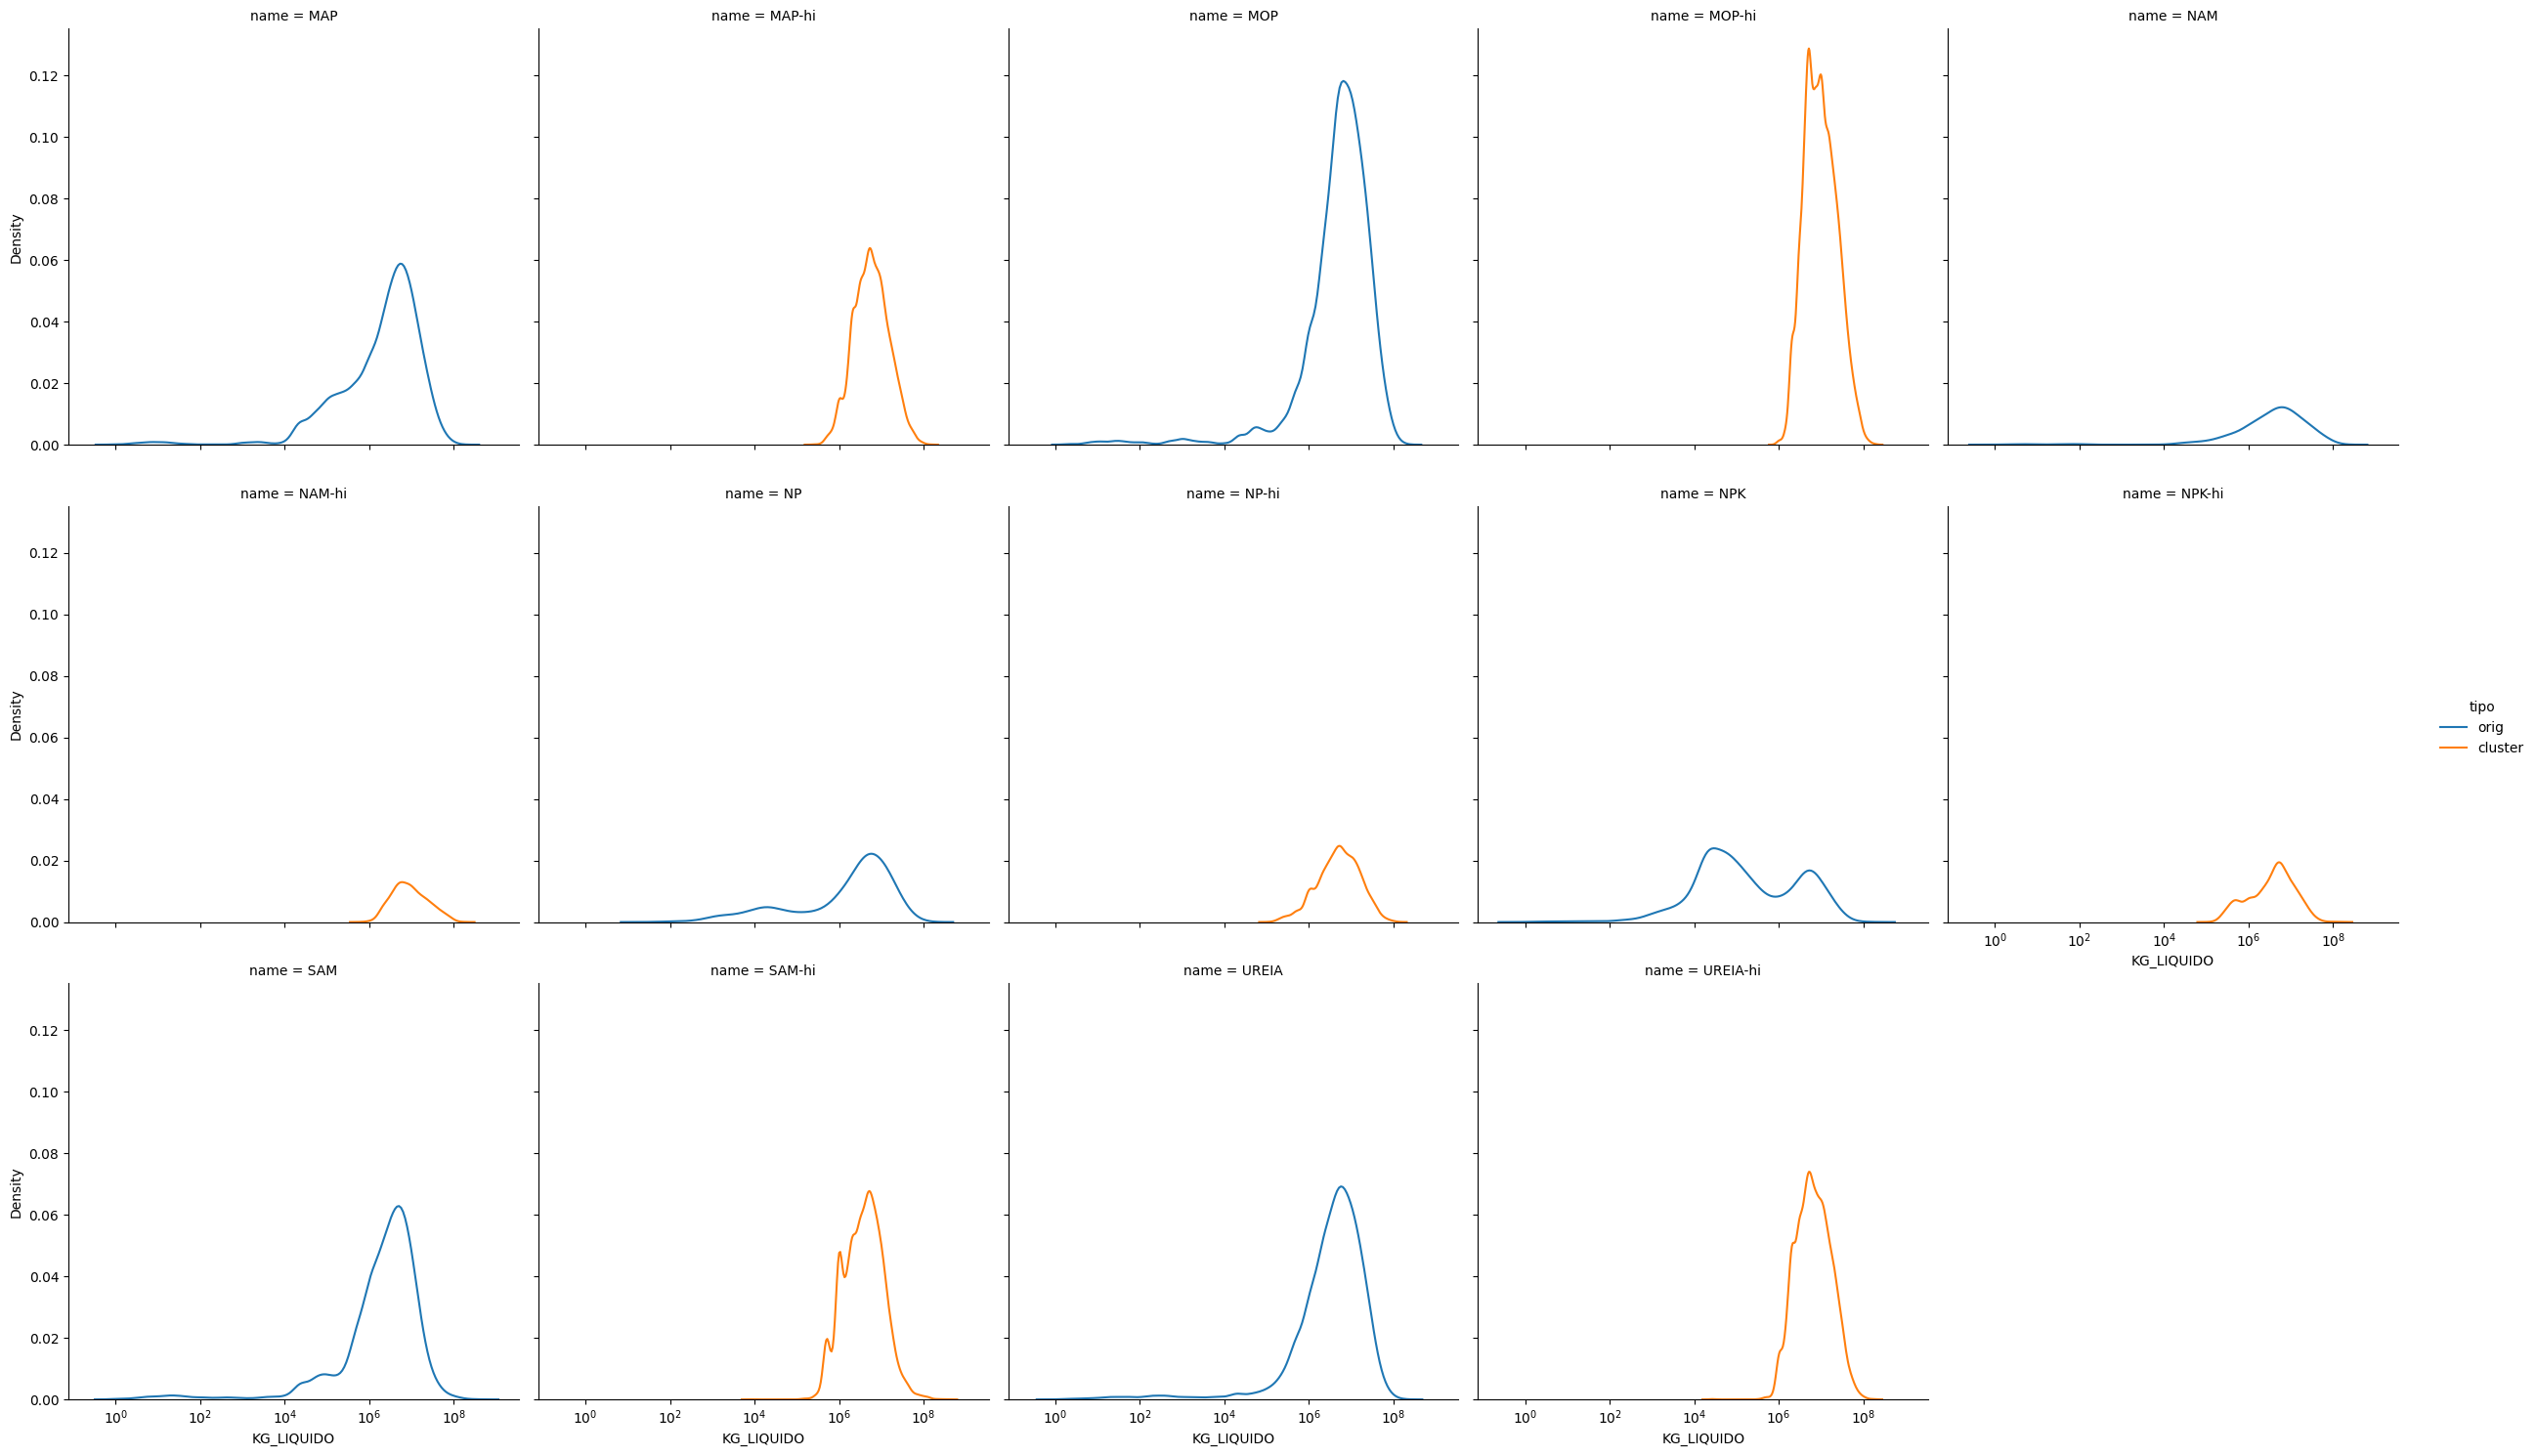

In [57]:
sns.displot(kind='kde',data=imp_fert2.sort_values(by='name'),x='KG_LIQUIDO',log_scale=True,col='name',col_wrap=5, hue='tipo')
plt.show()

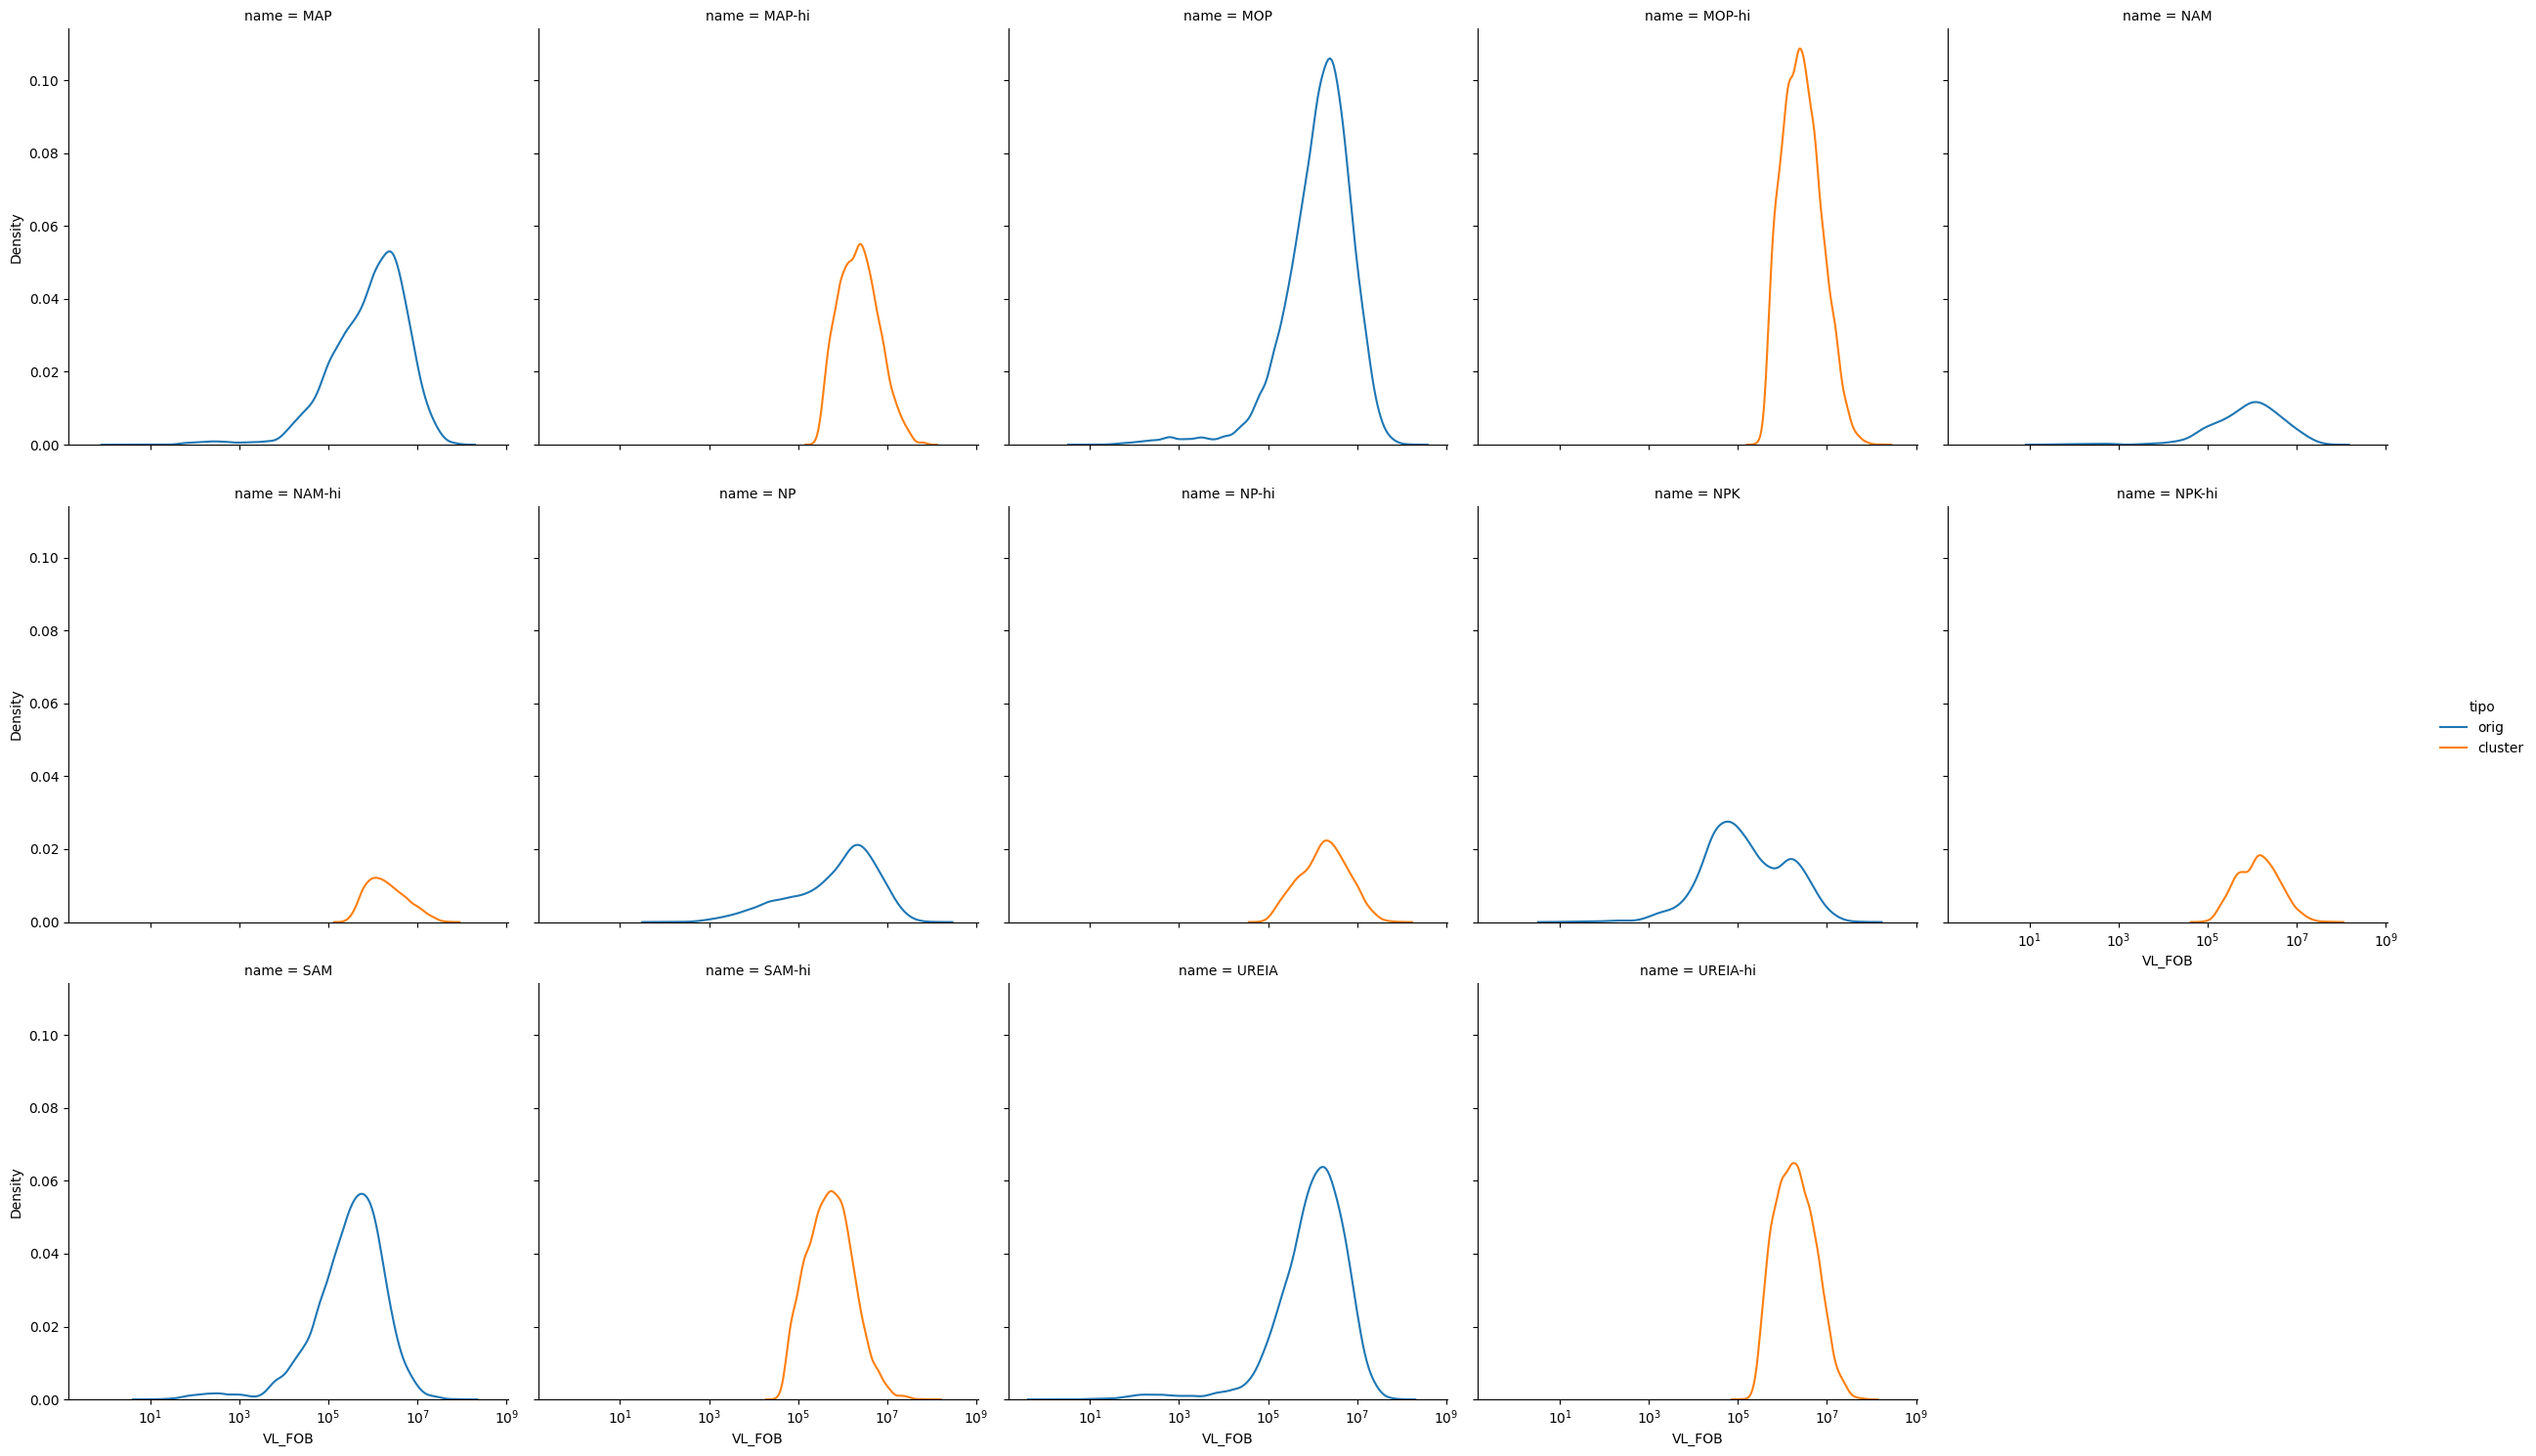

In [58]:
sns.displot(kind='kde',data=imp_fert2.sort_values(by='name'),x='VL_FOB',log_scale=True,col='name',col_wrap=5, hue='tipo')
plt.show()

In [59]:
# Salva a tabela importação
imp_fert.to_csv('~/git/BD/temp/imp_fert2.csv',index=False)

Cria tabela hi_imp_clusters com características dos clusters criados, que servirão para identificar novos dados a serem divulgados.

In [60]:
imp_fert=imp_fert.assign(log_kg=np.log10(imp_fert.KG_LIQUIDO))

In [61]:
imp_fert=imp_fert.assign(log_fob=np.log10(imp_fert.VL_FOB))

In [62]:
imp_fert=imp_fert.assign(log_frete=np.log10(imp_fert.VL_FRETE))

In [63]:
imp_fert_g=imp_fert.groupby(by=['CO_NCM','name'])

In [64]:
imp_fert_log_kg_mean=imp_fert_g.log_kg.mean().reset_index().rename(columns={'log_kg':'log_kg_mean'})

imp_fert_log_fob_mean=imp_fert_g.log_fob.mean().reset_index().rename(columns={'log_fob':'log_fob_mean'})

imp_fert_log_frete_mean=imp_fert_g.log_frete.mean().reset_index().rename(columns={'log_frete':'log_frete_mean'})

imp_fert_log_kg_std=imp_fert_g.log_kg.std().reset_index().rename(columns={'log_kg':'log_kg_std'})

imp_fert_log_fob_std=imp_fert_g.log_fob.std().reset_index().rename(columns={'log_fob':'log_fob_std'})

imp_fert_log_frete_std=imp_fert_g.log_frete.std().reset_index().rename(columns={'log_frete':'log_frete_std'})

In [65]:
hi_imp_clusters=imp_fert_log_kg_mean.merge(imp_fert_log_fob_mean).merge(imp_fert_log_frete_mean).merge(imp_fert_log_kg_std).merge(imp_fert_log_fob_std).merge(imp_fert_log_frete_std)

In [66]:
# Salva a tabela hi_imp_clusters
hi_imp_clusters.to_csv('~/git/BD/temp/hi_imp_clusters.csv',index=False)

In [67]:
round(hi_imp_clusters,1)

,CO_NCM,name,log_kg_mean,log_fob_mean,log_frete_mean,log_kg_std,log_fob_std,log_frete_std
0,31021010-hi,UREIA-hi,6.8,6.3,5.2,0.4,0.4,0.5
1,31022100-hi,SAM-hi,6.6,5.7,4.9,0.5,0.5,0.5
2,31023000-hi,NAM-hi,7.0,6.3,5.4,0.4,0.4,0.5
3,31042090-hi,MOP-hi,7.0,6.4,5.4,0.4,0.4,0.4
4,31052000-hi,NPK-hi,6.5,6.1,5.1,0.5,0.5,0.5
5,31054000-hi,MAP-hi,6.8,6.4,5.1,0.4,0.4,0.4
6,31055900-hi,NP-hi,6.7,6.3,5.1,0.5,0.5,0.5


Bye!